In [8]:
#Importing of all the necessary mods
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from sklearn.metrics import f1_score, roc_auc_score, multilabel_confusion_matrix, average_precision_score, precision_recall_curve

ImportError: cannot import name 'multilabel_confusion_matrix' from 'sklearn.metrics' (C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

In [9]:
# Reading the csv files
fashion_df = pd.read_csv("./datasets/fashion_text_dataset.csv")

In [10]:
# Showing the first few columns of the dataset
fashion_df.head(10)

,description,category
0,Sless Flippy Mini Dress,women dresses
1,Midi Pleated Skirt,women skirts
2,Stamos Mix Silk Raglan Knit Sweater,men outwear
3,Basic Training Tank Top,men tops
4,Fashion Camouflage Hooded Jacket,women outwear
5,Straight Leg Sweatpants,men trousers
6,Hooded Pull Over,men outwear
7,Ally 3/4 Spring Pullover,women outwear
8,Cropped Pleated Pants,women trousers
9,NB Athletics Archive Run Pants,men trousers


In [40]:
#This displays the relevant information of the dataframe
fashion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
description    2000 non-null object
category       2000 non-null object
dtypes: object(2)
memory usage: 31.3+ KB


In [43]:
#This displays the value count of the various categories
fashion_df.category.value_counts()

women outwear     238
men outwear       225
women skirts      216
women trousers    215
men trousers      210
women dresses     207
men tops          199
women tops        187
women shorts      184
men shorts        119
Name: category, dtype: int64

In [42]:
#This displays the number of unique categories in the dataframe
NO_OF_CLASSES = len(fashion_df.category.unique())
NO_OF_CLASSES

10

In [14]:
# check any text that are not processed yet
def print_text(index):
    example = fashion_df[fashion_df.index == index][['description', 'category']].values[0]
    if len(example) > 0:
        print('Description:',example[0])
        print('Product:', example[1])
        print()

In [44]:
# Examples of the text that is printed out using the index
print_text(7)
print_text(777)

Description: ally 3 4 spring pullover
Product: women outwear

Description: skinny fit stretch chino pants
Product: men trousers



In [16]:
# constants set to replace these symbols from the text
REPLACE_BY_SPACE = re.compile('[/(){}\[\]\|@,;-]')
BAD_SYMBOLS = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [45]:
#Function use to clean up the text
def clean_text(text):

    # Make all the text to lowercases
    text = text.lower() 
    
    # replace REPLACE_BY_SPACE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE with space.
    text = REPLACE_BY_SPACE.sub(' ', text) 
    
    # remove symbols which are in BAD_SYMBOLS from text. substitute the matched string in BAD_SYMBOLS with nothing. 
    text = BAD_SYMBOLS.sub('', text) 
    
    # remove stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    
    return text

In [47]:
#Save the new description after cleaning the text
fashion_df['description'] = fashion_df['description'].apply(clean_text)

In [48]:
#Print out the example texts again for double checking.
print_text(7)
print_text(777)

Description: ally 3 4 spring pullover
Product: women outwear

Description: skinny fit stretch chino pants
Product: men trousers



In [20]:
# The maximum number of words to be used. (most frequent)
MAX_FEATURES = 20000
# Max number of words in each description
MAX_LENGTH = 50
# This is fixed
EMBEDDING_DIM = 100

In [49]:
#Find the number of unique tokens
tokenizer = Tokenizer(num_words=MAX_FEATURES, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(fashion_df['description'].values)
word_index = tokenizer.word_index
print('Found {} unique tokens.'.format(len(word_index)))

Found 1569 unique tokens.


In [50]:
#Gets the shape of the data tensor
X = tokenizer.texts_to_sequences(fashion_df['description'].values)
X = pad_sequences(X, maxlen = MAX_LENGTH)
print('Shape of data tensor:{}'.format(X.shape))
#X  #DEBUG

Shape of data tensor:(2000, 50)


In [23]:
#Gets the shape of the label tensor
Y = pd.get_dummies(fashion_df['category']).values
print('Shape of label tensor:{}'.format(Y.shape))

Shape of label tensor:(2000, 10)


In [51]:
#Checks if the shape of the data tensor equal to the shape of the label tensor
X.shape[0] == Y.shape[0]

True

In [52]:
#Create the test and train sets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10)

In [53]:
#Print out the test and train set shapes
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1800, 50) (1800, 10)
(200, 50) (200, 10)


In [54]:
#Create and display the model
model = Sequential()
model.add(Embedding(MAX_FEATURES, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.2))
model.add(Dense(NO_OF_CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           2000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 2,237,066
Trainable params: 2,237,066
Non-trainable params: 0
_________________________________________________________________


In [55]:
#Variables for epochs and batch size
EPOCHS = 10
BATCH_SIZE = 64

In [56]:
#Train the model
models = model.fit(X_train, Y_train, 
                   epochs=EPOCHS, batch_size=BATCH_SIZE,validation_split=0.1,
                   callbacks=[EarlyStopping(monitor='val_loss', 
                                            patience=3, 
                                            min_delta=0.0001)])

C:\Users\Kate Kane\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Kate Kane\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
Train on 1620 samples, validate on 180 samples
Epoch 1/10
1620/1620 [==============================] - 4s 3ms/step - loss: 2.2753 - accuracy: 0.1364 - val_loss: 2.2545 - val_accuracy: 0.1389
Epoch 2/10
1620/1620 [==============================] - 3s 2ms/step - loss: 2.1684 - accuracy: 0.3407 - val_loss: 2.0568 - val_accuracy: 0.5722
Epoch 3/10
1620/1620 [=================

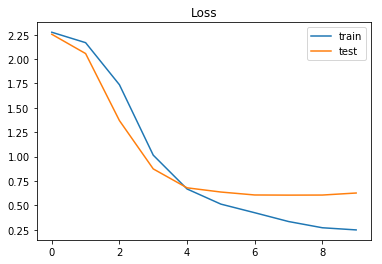

In [57]:
#Plot the Loss Graph of the model
plt.title('Loss')
plt.plot(models.history['loss'], label='train')
plt.plot(models.history['val_loss'], label='test')
plt.legend()
plt.show()

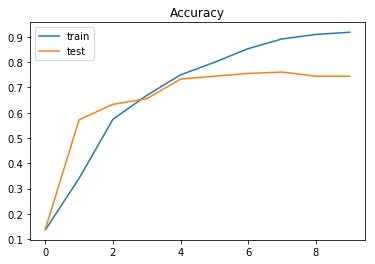

In [58]:
#Plot the accuracy graph of the model
plt.title('Accuracy')
plt.plot(models.history['accuracy'], label='train')
plt.plot(models.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [59]:
#Evaluate the accuracy of the test set and print out both loss and accuracy of test set
accuracy = model.evaluate(X_test,Y_test)
#print('Test set\nLoss: {}\nAccuracy: {}'.format(accuracy[0],accuracy[1]))
print('Test set\nLoss: {:0.5f}\nAccuracy: {:0.5f}'.format(accuracy[0],accuracy[1]))

200/200 [==============================] - 0s 568us/step
Test set
Loss: 0.58505
Accuracy: 0.78500


# Evaluation

In [33]:
# preprocess test data

yhat = model.predict(X_test, verbose=0)
preds_labels = [[1 if x > 0.5 else 0 for idx,x in enumerate(i) ] for i in yhat]

In [60]:
print(multilabel_confusion_matrix(Y_test, preds_labels))

NameError: name 'multilabel_confusion_matrix' is not defined

In [61]:
#Get the ROC-AUC Score
#print(average_precision_score(y_test, preds_labels))
#print(f1_score(y_test, preds_labels, average='micro'))
print('ROC-AUC Score:', roc_auc_score(Y_test, preds_labels))

ROC-AUC Score: 0.5050471883252395


# ----- Just for fun -----

In [62]:

# Test with new text description

TEXT = ["He is wearing a dark blue t-shirt"]

In [37]:
new_description = TEXT
seq = tokenizer.texts_to_sequences(new_description)
padded = pad_sequences(seq, maxlen=MAX_LENGTH)
pred = model.predict(padded)

In [38]:
labels = fashion_df.category.unique().tolist()
labels

['women dresses',
 'women skirts',
 'men outwear',
 'men tops',
 'women outwear',
 'men trousers',
 'women trousers',
 'women shorts',
 'men shorts',
 'women tops']

In [39]:
print(pred)
print(labels[np.argmax(pred)])

[[4.5596049e-03 3.9979164e-03 7.9064411e-01 6.2876926e-03 6.7986036e-04
  2.7317882e-03 1.1970524e-03 2.8352084e-04 1.7979378e-01 9.8247919e-03]]
men outwear


# ----- END -----